In [3]:
%load_ext autoreload
%autoreload 2
from condition_modeling import train
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
import pickle as pkl
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde
import matplotlib.cm as cm
import time
from joblib import dump, load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
objectives = [
    "calcine_temp",
    "sinter_temp",
    "calcine_time",
    "sinter_time"
]

models = ["rf", "xgb"]
featurization = "mp_fraction"

In [ ]:
for model in models:
    for objective in objectives:
        best_params, best_estimators, y_pred_train, y_pred_test, X_train_k, X_test_k, y_train_k, y_test_k, n_pts_train_k, n_pts_test_k = train(model=model, objective=objective, featurization=featurization)
        data = [best_params, y_pred_train, y_pred_test, X_train_k, X_test_k, y_train_k, y_test_k, n_pts_train_k, n_pts_test_k]
        for i, m in enumerate(best_estimators):
            dump(m, f'models/{model}_{featurization}_{objective}_{str(i)}.joblib')
        with open(f'models/{model}_{featurization}_{objective}_data.pkl', 'wb') as f:
            pkl.dump(data, f)
        

Returning extracted data of 51574/31782 reactions.



Shape of X: (12228, 102)
Shape of y: (12228,)
 44%|████▍     | 22/50 [01:18<01:17,  2.75s/trial, best loss: 111.13251673758135]

 # SHAP analysis 

In [152]:
all_shap_values_test = []
all_X_test = []
for regr, X_test in zip(best_estimators, X_test_k):
    explainer = shap.TreeExplainer(regr)
    shap_values_test = explainer.shap_values(X_test)
    all_shap_values_test.extend(shap_values_test)
    all_X_test.extend(X_test)
all_shap_values_test = np.array(all_shap_values_test)
all_X_test = np.array(all_X_test)

In [153]:
# make feature names for display
feature_labels = []
for label in X_columns:
    if 'prec' in label:
        label = label.replace("_", " ")
        feature_labels.append(label + "ursor")
    elif 'feature_exp' in label:
        feature_labels.append(label.replace("feature_exp_", "").replace("mp", "MP").replace("div", "std_dev").replace("_", " ").replace("max", "Max").replace("mean", "Mean").replace("std", "Std").replace("min", "Min"))
    else:
        label = label.replace("_", " ")
        feature_labels.append(label)

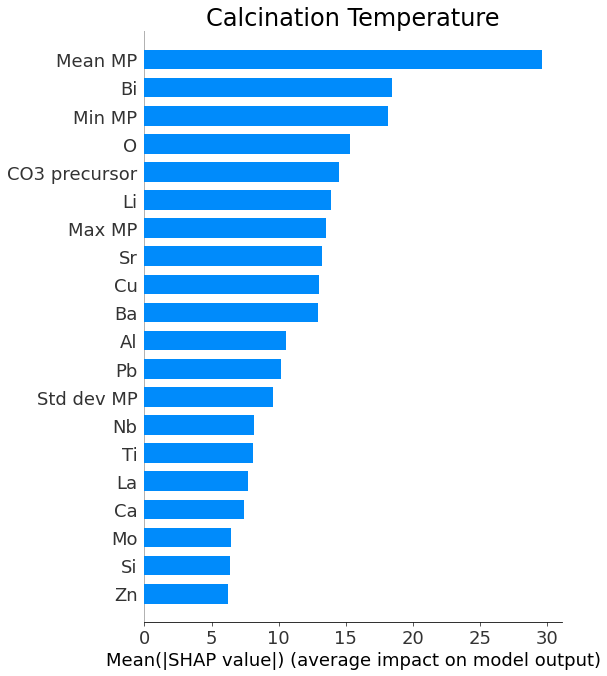

In [172]:
shap.summary_plot(all_shap_values_test, all_X_test, plot_type="bar", max_display=20, feature_names=feature_labels, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("Calcination Temperature", fontsize=24)
ax.set_xlabel("Mean(|SHAP value|) (average impact on model output)", fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
fig.tight_layout()

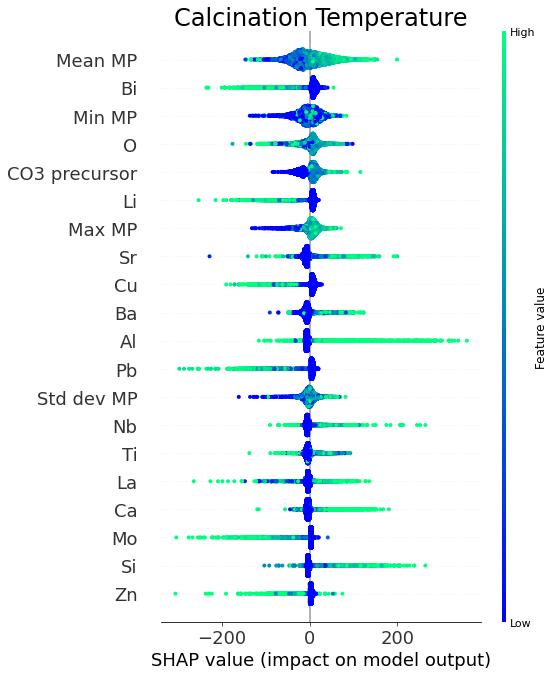

In [168]:
shap.summary_plot(all_shap_values_test, all_X_test, feature_names=feature_labels, max_display=20, cmap="winter", show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel("SHAP value (impact on model output)", fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_title("Calcination Temperature", fontsize=24)

fig.tight_layout()
# fig.savefig('figures/sinter_shap.png', dpi=150)

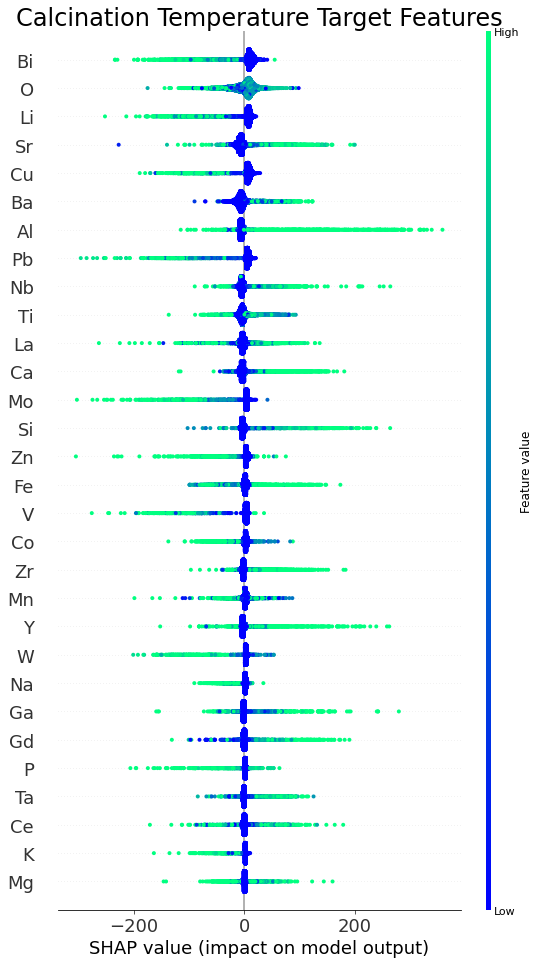

In [169]:
# look only at elemental features
el_inds = []
el_labels = []
for i in range(len(feature_labels)):
    if feature_labels[i] in feature_calculators.feature_labels():
        el_inds.append(i)
        el_labels.append(feature_labels[i])

        
shap.summary_plot(all_shap_values_test[:, el_inds], all_X_test[:, el_inds], plot_type="dot", feature_names=el_labels, max_display=30, cmap="winter", show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel("SHAP value (impact on model output)", fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_title("Calcination Temperature Target Features", fontsize=24)
fig.tight_layout()
# fig.savefig("figures/SHAP_el_feats_prec.png", dpi=150)

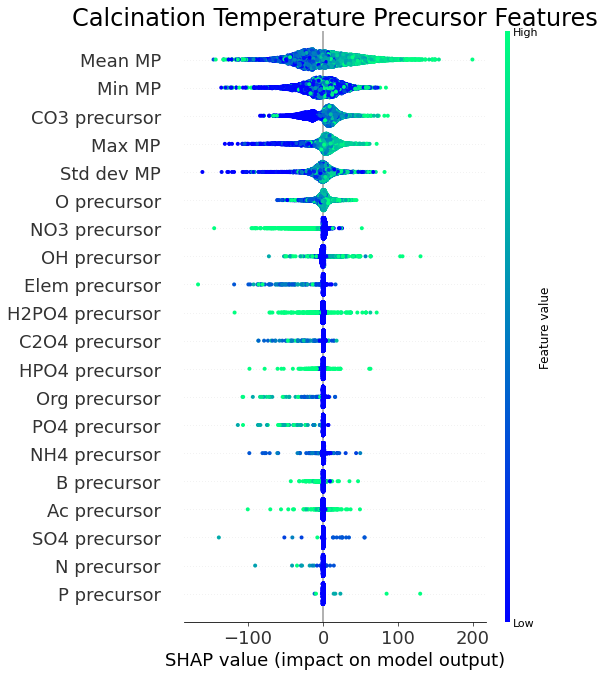

In [171]:
# look only at precursor features
prec_inds = []
prec_labels = []
for i in range(len(feature_labels)):
    if "MP" in feature_labels[i] or "precursor" in feature_labels[i]:
        prec_inds.append(i)
        prec_labels.append(feature_labels[i])
        
shap_values_test = np.array(shap_values_test)
        
shap.summary_plot(all_shap_values_test[:, prec_inds], all_X_test[:, prec_inds], plot_type="dot", feature_names=prec_labels, max_display=20, cmap="winter", show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel("SHAP value (impact on model output)", fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_title("Calcination Temperature Precursor Features", fontsize=24)
fig.tight_layout()
# fig.savefig("figures/SHAP_prec_feats_prec.png", dpi=150)